## Requirements

In [1]:
! pip install -q ultralytics
! pip install motmetrics
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 17.0 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import torch
import json
import os
import cv2
from ultralytics import YOLO
import motmetrics as mm
import numpy as np
from torchvision import transforms, models
import time
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: Tesla T4


## Training


### Process the training data to make it compatible with the YOLO format

In [4]:
def extract_frames(video_path, images_dir, video_index, frame_step=3):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0

    os.makedirs(images_dir, exist_ok=True)

    while cap.isOpened() and extracted_count < 600:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_step == 0:
            frame_name = f"frame_{video_index}_{extracted_count:04d}.jpg"
            cv2.imwrite(os.path.join(images_dir, frame_name), frame)
            extracted_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {extracted_count} frames from video {video_index}.")

def parse_annotations(outputs_path, images_dir, labels_dir, video_index):
    with open(outputs_path, 'r') as f:
        data = json.load(f)

    os.makedirs(labels_dir, exist_ok=True)
    label_count = 0
    print("Number of frames in annotations: ", len(data['objects']))

    for obj in data['objects']:
        pig_id = int(obj['id'])
        print(f"Processing Pig ID: {pig_id}")

        last_bbox = None
        frames_dict = {frame['frameNumber']: frame['bbox'] for frame in obj['frames']}

        for frame_index in range(600):
            if frame_index in frames_dict:
                last_bbox = frames_dict[frame_index]

            if last_bbox is not None:
                frame_image = f"frame_{video_index}_{frame_index:04d}.jpg"
                img_path = os.path.join(images_dir, frame_image)

                if not os.path.exists(img_path):
                    print(f"Frame {frame_image} does not exist. Skipping.")
                    continue

                img = cv2.imread(img_path)
                if img is None:
                    print(f"Frame {frame_image} is missing. Skipping.")
                    continue

                img_h, img_w, _ = img.shape

                x, y, w, h = last_bbox['x'], last_bbox['y'], last_bbox['width'], last_bbox['height']
                x_center = (x + w / 2) / img_w
                y_center = (y + h / 2) / img_h
                norm_w = w / img_w
                norm_h = h / img_h
                label_file = f"frame_{video_index}_{frame_index:04d}.txt"
                label_path = os.path.join(labels_dir, label_file)
                with open(label_path, 'a') as label_file:
                    label_file.write(f"{pig_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")
                    label_count += 1

    print(f"Annotations parsed. Total Labels: {label_count} in {labels_dir}.")

def process_videos(dataset_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    video_index = 0

    for subfolder in os.listdir(dataset_dir):
        subfolder_path = os.path.join(dataset_dir, subfolder)

        if os.path.isdir(subfolder_path):
            print(f"\nProcessing Subfolder: {subfolder}")
            outputs_path = os.path.join(subfolder_path, "output.json")
            video_path = os.path.join(subfolder_path, "color.mp4")

            if os.path.exists(outputs_path) and os.path.exists(video_path):
                images_dir = os.path.join(output_dir, "images")
                labels_dir = os.path.join(output_dir, "labels")
                extract_frames(video_path, images_dir, video_index)
                parse_annotations(outputs_path, images_dir, labels_dir, video_index)
                video_index += 1
            else:
                print(f"Warning: Missing files in {subfolder}")
                if not os.path.exists(outputs_path):
                    print("  - Missing: output.json")
                if not os.path.exists(video_path):
                    print("  - Missing: color.mp4")

    print("\nAll subfolders have been processed.")
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")

    image_count = len([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
    label_count = len([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

    print("\nValidation Check:")
    print(f"Images: {image_count}, Labels: {label_count}")
    if image_count != label_count:
        print("Mismatch Detected: The number of images and labels do not match.")
    else:
        print("All Images have corresponding Labels.")


In [5]:
data_dir = "./PigDataset"
train_dir = '/content/drive/MyDrive/TrackingRequirements/dataset/train'
process_videos(train_dir, data_dir)

os.makedirs(data_dir, exist_ok=True)
os.makedirs(os.path.join(data_dir, "images"), exist_ok=True)


Processing Subfolder: 000010
Extracted 600 frames from video 0.
Number of frames in annotations:  8
Processing Pig ID: 5
Processing Pig ID: 3
Processing Pig ID: 1
Processing Pig ID: 0
Processing Pig ID: 6
Processing Pig ID: 4
Processing Pig ID: 7
Processing Pig ID: 2
Annotations parsed. Total Labels: 4800 in ./PigDataset/labels.

Processing Subfolder: 000028
Extracted 600 frames from video 1.
Number of frames in annotations:  8
Processing Pig ID: 7
Processing Pig ID: 1
Processing Pig ID: 5
Processing Pig ID: 3
Processing Pig ID: 2
Processing Pig ID: 4
Processing Pig ID: 0
Processing Pig ID: 6
Annotations parsed. Total Labels: 4800 in ./PigDataset/labels.

Processing Subfolder: 000002
Extracted 600 frames from video 2.
Number of frames in annotations:  8
Processing Pig ID: 3
Processing Pig ID: 4
Processing Pig ID: 6
Processing Pig ID: 7
Processing Pig ID: 2
Processing Pig ID: 1
Processing Pig ID: 5
Processing Pig ID: 0
Annotations parsed. Total Labels: 4800 in ./PigDataset/labels.

Pro

In [6]:
test_data_dir = "./PigDatasetTest"
test_dir = '/content/drive/MyDrive/TrackingRequirements/dataset/test'
process_videos(test_dir, test_data_dir)


Processing Subfolder: 000078
Extracted 600 frames from video 0.
Number of frames in annotations:  8
Processing Pig ID: 5
Processing Pig ID: 4
Processing Pig ID: 7
Processing Pig ID: 0
Processing Pig ID: 2
Processing Pig ID: 1
Processing Pig ID: 3
Processing Pig ID: 6
Annotations parsed. Total Labels: 4800 in ./PigDatasetTest/labels.

Processing Subfolder: 000113
Extracted 600 frames from video 1.
Number of frames in annotations:  8
Processing Pig ID: 3
Processing Pig ID: 2
Processing Pig ID: 1
Processing Pig ID: 7
Processing Pig ID: 4
Processing Pig ID: 6
Processing Pig ID: 5
Processing Pig ID: 0
Annotations parsed. Total Labels: 4800 in ./PigDatasetTest/labels.

Processing Subfolder: 000208
Extracted 600 frames from video 2.
Number of frames in annotations:  8
Processing Pig ID: 1
Processing Pig ID: 6
Processing Pig ID: 2
Processing Pig ID: 3
Processing Pig ID: 5
Processing Pig ID: 7
Processing Pig ID: 0
Processing Pig ID: 4
Annotations parsed. Total Labels: 4800 in ./PigDatasetTest/

In [7]:
# Create a YAML configuration for YOLO training
dataset_yaml = f"""path: .
train: {data_dir}/images  # Training images directory
val: {test_data_dir}/images     # Validation images directory
nc: 8           # Number of classes (8 pigs, IDs 0-7)
names:
  0: pig_0
  1: pig_1
  2: pig_2
  3: pig_3
  4: pig_4
  5: pig_5
  6: pig_6
  7: pig_7
"""

yaml_path = os.path.join(data_dir, "pig_dataset.yaml")
with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print(f"Dataset YAML file created at: {yaml_path}")


Dataset YAML file created at: ./PigDataset/pig_dataset.yaml


In [8]:
model = YOLO("yolov9c.pt")

model.train(
    data=yaml_path,
    epochs=25,
    imgsz=640,
    batch=16,
    project="./YoloRuns",
    name="pig_yolo_v9_test_1",
    workers=4,
    device=0
)


100%|██████████| 49.4M/49.4M [00:01<00:00, 26.1MB/s]


Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./PigDataset/pig_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9c.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pig_yolo_v9_test_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

100%|██████████| 755k/755k [00:00<00:00, 109MB/s]

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

  8                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPELAN         [512, 512, 256]               
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1   3119616  ultralytics.nn.modules.block.RepNCSPELAN4    [1024, 512, 512, 256, 1]      
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    912640  ultralytics.nn.modules.block.RepNCSPELAN4    [1024, 256, 256, 128, 1]      
 16                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256,

100%|██████████| 5.35M/5.35M [00:00<00:00, 344MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3233.7±662.3 MB/s, size: 315.0 KB)


train: Scanning /content/PigDataset/labels... 4200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4200/4200 [00:02<00:00, 1886.48it/s]


train: New cache created: /content/PigDataset/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1551.7±1181.3 MB/s, size: 303.9 KB)


val: Scanning /content/PigDatasetTest/labels... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:03<00:00, 980.40it/s] 


val: New cache created: /content/PigDatasetTest/labels.cache
Plotting labels to YoloRuns/pig_yolo_v9_test_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to YoloRuns/pig_yolo_v9_test_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      10.2G       1.37      1.321      1.463        131        640: 100%|██████████| 263/263 [03:37<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:46<00:00,  2.04it/s]


                   all       3000      24000      0.418      0.395      0.361       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      10.4G       1.19     0.7331      1.311        124        640: 100%|██████████| 263/263 [03:31<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.08it/s]


                   all       3000      24000      0.562      0.437      0.467      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      10.4G      1.142     0.6733      1.289        133        640: 100%|██████████| 263/263 [03:30<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]

                   all       3000      24000      0.527      0.449      0.451      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      10.4G      1.098     0.6237       1.27        141        640: 100%|██████████| 263/263 [03:29<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]

                   all       3000      24000      0.499      0.491      0.457      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      10.4G      1.038     0.5754      1.237        151        640: 100%|██████████| 263/263 [03:29<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.07it/s]

                   all       3000      24000      0.573      0.484      0.506      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      10.4G     0.9984     0.5393      1.225        110        640: 100%|██████████| 263/263 [03:30<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.07it/s]

                   all       3000      24000       0.51      0.471      0.484      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      10.3G     0.9586     0.5114      1.199        124        640: 100%|██████████| 263/263 [03:29<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]

                   all       3000      24000      0.489      0.493      0.461      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      10.5G     0.9338     0.4873      1.192        123        640: 100%|██████████| 263/263 [03:29<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]

                   all       3000      24000      0.494      0.497      0.439       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      10.4G     0.8976     0.4699      1.176        108        640: 100%|██████████| 263/263 [03:29<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]

                   all       3000      24000      0.569      0.515      0.515      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      10.4G     0.8732     0.4493      1.155        108        640: 100%|██████████| 263/263 [03:29<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


                   all       3000      24000       0.47      0.448      0.457      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      10.4G     0.8438     0.4325      1.141        130        640: 100%|██████████| 263/263 [03:28<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.05it/s]

                   all       3000      24000      0.474      0.476      0.442      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      10.4G     0.8236     0.4213      1.127        149        640: 100%|██████████| 263/263 [03:29<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:46<00:00,  2.04it/s]

                   all       3000      24000      0.618      0.428      0.476      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      10.4G      0.797     0.4074      1.117        151        640: 100%|██████████| 263/263 [03:29<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:46<00:00,  2.03it/s]

                   all       3000      24000      0.536      0.449      0.491       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      10.4G       0.78     0.3896      1.096        116        640: 100%|██████████| 263/263 [03:29<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:46<00:00,  2.03it/s]

                   all       3000      24000      0.453       0.53      0.491      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      10.4G      0.758     0.3811      1.091        144        640: 100%|██████████| 263/263 [03:29<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.05it/s]

                   all       3000      24000      0.559      0.513      0.509      0.248


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      10.3G     0.7131     0.3101      1.073         64        640: 100%|██████████| 263/263 [03:28<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.08it/s]

                   all       3000      24000      0.525       0.46      0.469      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      10.3G      0.686     0.2987      1.063         64        640: 100%|██████████| 263/263 [03:27<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]

                   all       3000      24000      0.476      0.519       0.47      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      10.3G     0.6595     0.2902      1.043         64        640: 100%|██████████| 263/263 [03:27<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.14it/s]

                   all       3000      24000       0.42      0.487      0.452      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      10.3G     0.6374     0.2788      1.033         62        640: 100%|██████████| 263/263 [03:28<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]

                   all       3000      24000      0.464       0.47      0.447      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      10.3G      0.618     0.2681      1.023         64        640: 100%|██████████| 263/263 [03:28<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.08it/s]

                   all       3000      24000      0.425      0.527       0.44       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      10.3G     0.5891     0.2568      1.007         64        640: 100%|██████████| 263/263 [03:28<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.08it/s]

                   all       3000      24000      0.497        0.5      0.462      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      10.3G     0.5672     0.2483     0.9941         64        640: 100%|██████████| 263/263 [03:28<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:45<00:00,  2.08it/s]

                   all       3000      24000      0.476      0.505      0.467      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      10.3G     0.5469     0.2411     0.9863         64        640: 100%|██████████| 263/263 [03:27<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]

                   all       3000      24000       0.47      0.516      0.459      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      10.4G     0.5247     0.2311     0.9719         64        640: 100%|██████████| 263/263 [03:27<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]

                   all       3000      24000      0.488      0.538        0.5      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      10.3G     0.5063     0.2222     0.9631         64        640: 100%|██████████| 263/263 [03:28<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]

                   all       3000      24000      0.474      0.516      0.482      0.238



25 epochs completed in 1.782 hours.
Optimizer stripped from YoloRuns/pig_yolo_v9_test_1/weights/last.pt, 51.6MB
Optimizer stripped from YoloRuns/pig_yolo_v9_test_1/weights/best.pt, 51.6MB

Validating YoloRuns/pig_yolo_v9_test_1/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9c summary (fused): 156 layers, 25,325,416 parameters, 0 gradients, 102.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:50<00:00,  1.88it/s]


                   all       3000      24000      0.573      0.484      0.506      0.256
                 pig_0       3000       3000      0.551       0.77      0.719      0.366
                 pig_1       3000       3000      0.946      0.429      0.603      0.311
                 pig_2       3000       3000       0.42      0.156       0.29      0.152
                 pig_3       3000       3000      0.659      0.615      0.674      0.361
                 pig_4       3000       3000      0.349      0.654      0.334      0.134
                 pig_5       3000       3000      0.566      0.403      0.495       0.26
                 pig_6       3000       3000      0.415      0.345      0.299      0.118
                 pig_7       3000       3000       0.68        0.5      0.635      0.344
Speed: 0.1ms preprocess, 8.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to YoloRuns/pig_yolo_v9_test_1


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3b8cb32d90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

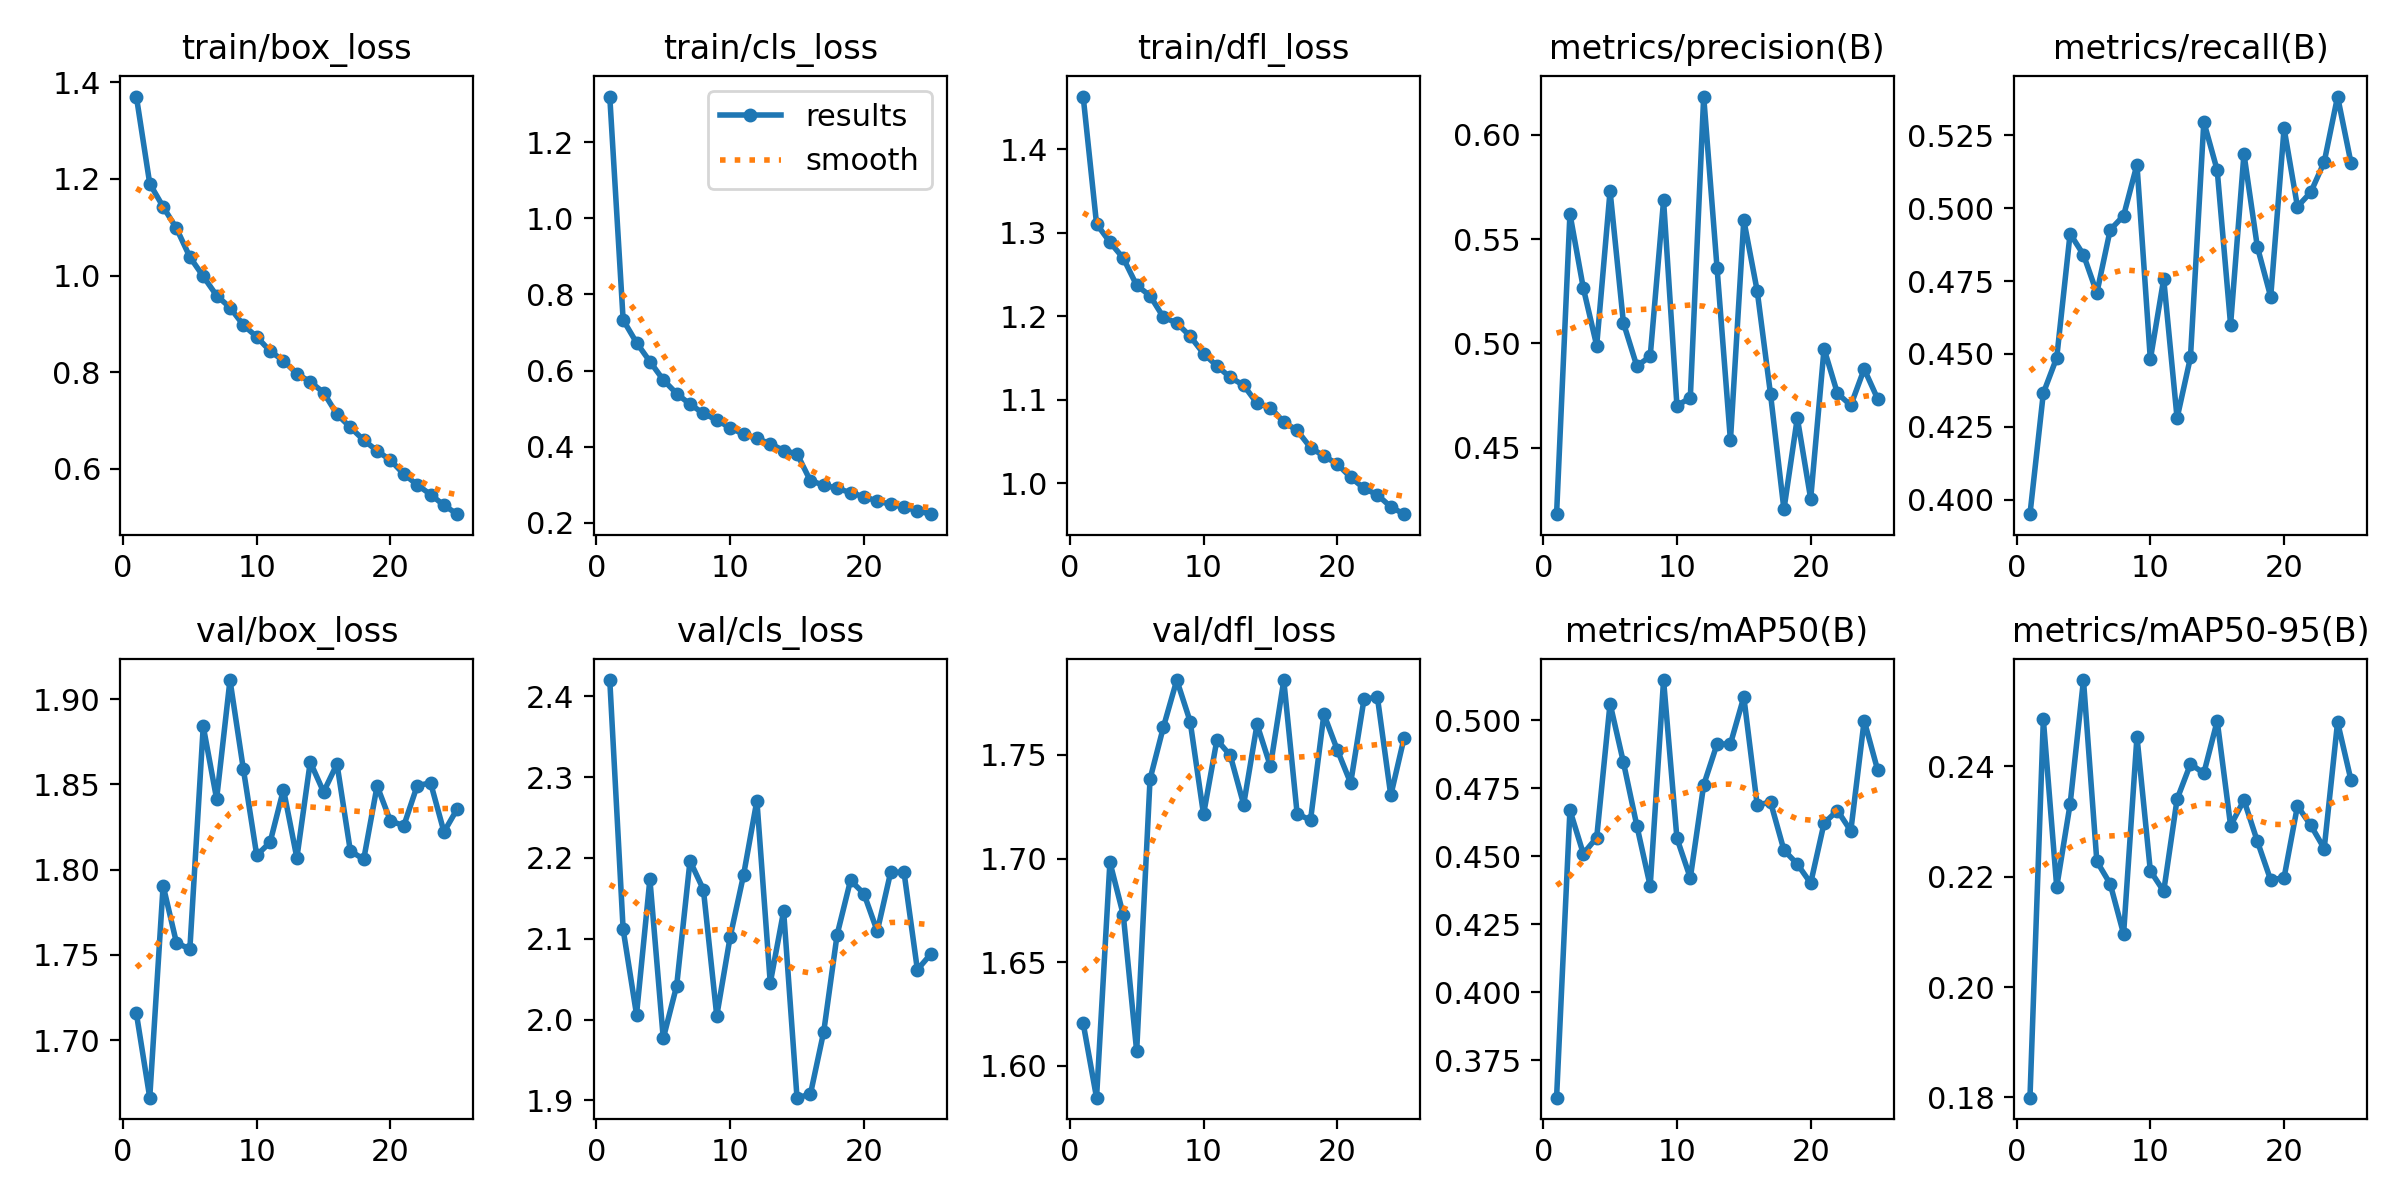

In [9]:
# Display the training results
from IPython.display import Image, display

# Display the training curve
results_image = "./YoloRuns/pig_yolo_v9_test_1/results.png"
display(Image(results_image))


In [10]:
# ! cp ./YoloRuns/pig_yolo_v9_test_1/weights/best.pt /content/drive/MyDrive/

In [11]:
metrics = model.val()

print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9c summary (fused): 156 layers, 25,325,416 parameters, 0 gradients, 102.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2935.4±1534.8 MB/s, size: 336.1 KB)


val: Scanning /content/PigDatasetTest/labels.cache... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:12<00:00,  2.60it/s]


                   all       3000      24000      0.573      0.484      0.506      0.256
                 pig_0       3000       3000      0.551       0.77      0.719      0.366
                 pig_1       3000       3000      0.946      0.429      0.603      0.311
                 pig_2       3000       3000      0.419      0.156       0.29      0.152
                 pig_3       3000       3000      0.659      0.615      0.673      0.361
                 pig_4       3000       3000      0.349      0.654      0.334      0.133
                 pig_5       3000       3000      0.566      0.403      0.495      0.259
                 pig_6       3000       3000      0.415      0.345      0.299      0.118
                 pig_7       3000       3000      0.679        0.5      0.635      0.344
Speed: 0.3ms preprocess, 17.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to YoloRuns/pig_yolo_v9_test_12
Precision: 0.5731
Recall: 0.4840
mAP@0.5: 0.5061
mAP@0.5:0.95: 0.2557


## Detection + Tracking Testing

In [12]:
# Load the trained model (best weights)
pretrained_yolo_weights = '/content/drive/MyDrive/TrackingRequirements/YOLOWeights/best.pt'

trained_model = YOLO(pretrained_yolo_weights)

### Testing Single Video Tracking

In [13]:
test_video = "/content/drive/MyDrive/TrackingRequirements/dataset/train/000002/color.mp4"

In [14]:
# Use the trained model for inference on a test video
results = trained_model.track(
    source=test_video,     # Path to the test video
    conf=0.25,             # Confidence threshold
    iou=0.45,              # IOU threshold
    show=False,             # Display video
    save=True,             # Save results
    save_txt=True,         # Save detection results as text files
    save_conf=True,        # Save confidence scores
    save_crop=False,       # Save cropped detections
    tracker="bytetrack.yaml"  # Use ByteTrack for multi-object tracking
)

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1800) /content/drive/MyDrive/TrackingRequirements/dataset/train/000002/color.mp4: 384x640 1 pig_0, 2 pig_1s, 1 pig_2, 1 pig_3, 1 pig_4, 1 pig_5, 2 pig_7s, 89.8ms
video 1/1 (frame 2/1800) /content/drive/MyDrive/TrackingRe

In [15]:
acc = mm.MOTAccumulator(auto_id=True)

tracking_results_dir = "./runs/detect/track/labels"

def parse_tracking_results(tracking_results_dir):
    frame_data = {}

    for file in os.listdir(tracking_results_dir):
        if file.endswith(".txt"):
            frame_number = int(file.split(".")[0].split("_")[-1])
            frame_data[frame_number] = []

            with open(os.path.join(tracking_results_dir, file), "r") as f:
                for line in f.readlines():
                    data = line.strip().split()
                    track_id = int(data[0])
                    frame_data[frame_number].append(track_id)

    return frame_data

tracking_data = parse_tracking_results(tracking_results_dir)

if len(tracking_data) == 0:
    print("No tracking data found. Please check the tracking directory.")
else:
    previous_frame_tracks = {}
    fragmentation = 0

    for frame, track_ids in tracking_data.items():
        gt_ids = list(previous_frame_tracks.keys())
        pred_ids = track_ids

        distances = [[0] * len(pred_ids) for _ in gt_ids] if gt_ids else []

        acc.update(
            gt_ids,                 # Ground Truth IDs
            pred_ids,               # Predicted IDs
            distances               # Zero distances (identity match)
        )

        # Track continuity for fragmentation
        for track_id in pred_ids:
            if track_id not in previous_frame_tracks:
                previous_frame_tracks[track_id] = frame
            else:
                if frame - previous_frame_tracks[track_id] > 1:  # Fragmentation occurs
                    fragmentation += 1
                previous_frame_tracks[track_id] = frame

    mh = mm.metrics.create()
    summary = mh.compute(
        acc,
        metrics=['mota', 'idf1', 'idp', 'idr', 'num_switches'],
        name='Tracking'
    )
    summary['Fragmentation'] = fragmentation

    print("\n================ Tracking Metrics ================")
    print(summary)



================ Tracking Metrics ================
              mota     idf1       idp       idr  num_switches  Fragmentation
Tracking  0.925723  1.00315  1.042293  1.006879           724           7015


In [24]:
# !cp /content/runs/detect/track/color.avi /content/drive/MyDrive/

## Behavior Analysis

## Testing Evaluation

In [ ]:
! mkdir outputs

In [ ]:
import os
import json
import cv2
import numpy as np
from ultralytics import YOLO
import torch
from torchvision import transforms, models
from PIL import Image

model_path = '/content/drive/MyDrive/TrackingRequirements/EfficientNetWeights/best_efficientnet_b3.pth'
yolo_weights = '/content/drive/MyDrive/TrackingRequirements/YOLOWeights/best.pt'

model = YOLO(yolo_weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

effnet_model = models.efficientnet_b3(pretrained=False)
effnet_model.classifier[1] = torch.nn.Linear(effnet_model.classifier[1].in_features, 2)
effnet_model.load_state_dict(torch.load(model_path, map_location=device))
effnet_model = effnet_model.to(device).eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

FEEDER_ZONE = [(305, 450), (771, 698)]
DRINKER_ZONES = [
    [(1016, 420), (1149, 566)],  # Drinker Zone 1
    [(189, 463), (346, 717)]   # Drinker Zone 2
]

def is_in_zone(centroid, zones):
    (x, y) = centroid
    for zone in zones:
        if zone[0][0] <= x <= zone[1][0] and zone[0][1] <= y <= zone[1][1]:
            return True
    return False

def classify_behavior(frame, x1, y1, x2, y2, centroid, movement):
    if movement < 20:
        if is_in_zone(centroid, [FEEDER_ZONE]):
            return "Feeding"
        elif is_in_zone(centroid, DRINKER_ZONES):
            return "Drinking"
        else:
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                return "Unknown"

            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(crop_pil).unsqueeze(0).to(device)
            with torch.no_grad():
                output = effnet_model(input_tensor)
                _, pred = torch.max(output, 1)
                return "Lying" if pred.item() == 0 else "Standing"
    else:
        return "Moving"

def generate_pred_output(test_dir, output_dir, frame_step=3):
    os.makedirs(output_dir, exist_ok=True)

    for subfolder in os.listdir(test_dir):
        subfolder_path = os.path.join(test_dir, subfolder)
        video_path = os.path.join(subfolder_path, "color.mp4")
        json_path = os.path.join(subfolder_path, "output.json")

        if not os.path.exists(video_path) or not os.path.exists(json_path):
            print(f"Missing files in {subfolder}. Skipping.")
            continue

        output_subdir = os.path.join(output_dir, subfolder)
        os.makedirs(output_subdir, exist_ok=True)
        output_pred_path = os.path.join(output_subdir, "output_pred.json")

        with open(json_path, 'r') as f:
            gt_data = json.load(f)

        pred_data = {
            "videoFileName": gt_data.get("videoFileName", ""),
            "fullVideoFilePath": gt_data.get("fullVideoFilePath", ""),
            "stepSize": gt_data.get("stepSize", 0.1),
            "config": gt_data.get("config", {}),
            "objects": []
        }

        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        centroid_history = {}

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % frame_step == 0:
                results_list = model.track(frame, persist=True, verbose=False)
                if len(results_list) == 0:
                    frame_count += 1
                    continue

                results = results_list[0]

                for box in results.boxes:
                    box_coords = box.xyxy[0].tolist() if isinstance(box.xyxy[0], torch.Tensor) else box.xyxy[0]
                    x1, y1, x2, y2 = map(int, box_coords[:4])
                    track_id = int(box.id) if box.id is not None else -1

                    if track_id == -1:
                        continue

                    centroid = ((x1 + x2) // 2, (y1 + y2) // 2)

                    if track_id not in centroid_history:
                        centroid_history[track_id] = []

                    centroid_history[track_id].append(centroid)

                    movement = 0
                    if len(centroid_history[track_id]) > 5:
                        movement = np.linalg.norm(
                            np.array(centroid_history[track_id][-1]) -
                            np.array(centroid_history[track_id][-6])
                        )

                    pred_behavior = classify_behavior(frame, x1, y1, x2, y2, centroid, movement)

                    obj_data = {
                        "id": str(track_id),
                        "frames": [{
                            "frameNumber": frame_count//3,
                            "bbox": {
                                "x": x1,
                                "y": y1,
                                "width": x2 - x1,
                                "height": y2 - y1
                            },
                            "isGroundTruth": False,
                            "visible": True,
                            "behaviour": pred_behavior
                        }]
                    }

                    existing_obj = next((o for o in pred_data["objects"] if o["id"] == str(track_id)), None)
                    if existing_obj:
                        existing_obj["frames"].append(obj_data["frames"][0])
                    else:
                        pred_data["objects"].append(obj_data)

            frame_count += 1

        cap.release()
        print(f"Processed {subfolder} - Saved to {output_pred_path}")

        with open(output_pred_path, 'w') as f:
            json.dump(pred_data, f, indent=4)

test_dir = '/content/drive/MyDrive/TrackingRequirements/dataset/test/'
output_dir = '/content/outputs/'
generate_pred_output(test_dir, output_dir, frame_step=3)


Using device: cuda
Processed 000078 - Saved to /content/outputs/000078/output_pred.json
Processed 000113 - Saved to /content/outputs/000113/output_pred.json
Processed 000208 - Saved to /content/outputs/000208/output_pred.json
Processed 000036 - Saved to /content/outputs/000036/output_pred.json
Processed 000060 - Saved to /content/outputs/000060/output_pred.json


In [ ]:
# ! cp -r /content/outputs/ /content/drive/MyDrive/

In [ ]:
import json
import pandas as pd
import os

gt_root = '/content/drive/MyDrive/TrackingRequirements/dataset/test'
pred_root = 'outputs/'

total_behaviors_pred = {'Standing': 0, 'Moving': 0, 'Lying': 0, 'Feeding': 0, 'Drinking': 0}
total_behaviors_gt = {'Standing': 0, 'Moving': 0, 'Lying': 0, 'Feeding': 0, 'Drinking': 0}
total_tp = {'Standing': 0, 'Moving': 0, 'Lying': 0, 'Feeding': 0, 'Drinking': 0}
total_fp = {'Standing': 0, 'Moving': 0, 'Lying': 0, 'Feeding': 0, 'Drinking': 0}
total_fn = {'Standing': 0, 'Moving': 0, 'Lying': 0, 'Feeding': 0, 'Drinking': 0}
total_num_switches = 0
total_fragmentation = 0

behavior_mapping = {
    'standing': 'Standing',
    'walk': 'Moving',
    'playwithtoy': 'Moving',
    'investigating': 'Moving',
    'drink': 'Drinking',
    'eat': 'Feeding',
    'sleep': 'Lying',
    'run': 'Moving'
}

for subfolder in os.listdir(gt_root):
    gt_file = os.path.join(gt_root, subfolder, 'output.json')
    pred_file = os.path.join(pred_root, subfolder, 'output_pred.json')

    if not os.path.exists(gt_file) or not os.path.exists(pred_file):
        print(f"[WARNING] Missing files for {subfolder}. Skipping.")
        continue

    with open(gt_file) as f:
        data_gt = json.load(f)

    with open(pred_file) as f:
        data_pred = json.load(f)

    gt_frames = {}
    for obj in data_gt['objects']:
        for frame in obj['frames']:
            mapped_behavior = behavior_mapping.get(frame['behaviour'].lower(), None)
            if mapped_behavior:
                gt_frames[frame['frameNumber']] = mapped_behavior

    for obj in data_pred['objects']:
        for frame in obj['frames']:
            pred_behavior = frame['behaviour']
            frame_num = frame['frameNumber']

            if frame_num in gt_frames:
                if pred_behavior == gt_frames[frame_num]:
                    total_tp[pred_behavior] += 1
                else:
                    total_fp[pred_behavior] += 1
                    total_fn[gt_frames[frame_num]] += 1
            else:
                total_fp[pred_behavior] += 1

    total_num_switches += len(set(obj['id'] for obj in data_pred['objects']))
    total_fragmentation += sum(len(obj['frames']) for obj in data_pred['objects'])

# Calculate metrics across all files
metrics = []
for behavior in total_tp.keys():
    tp = total_tp[behavior]
    fp = total_fp[behavior]
    fn = total_fn[behavior]

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    metrics.append([behavior, precision * 100, recall * 100, f1_score * 100, tp, fp, fn])


df_metrics = pd.DataFrame(metrics, columns=['Behavior', 'AP(%)', 'TP(%)', 'FP(%)', 'TruePositives', 'FalsePositives', 'FalseNegatives'])

with open('accuracy.txt', 'w') as f:
    f.write("================ Overall Tracking Metrics ================\n")
    f.write(f"Total Num Switches: {total_num_switches}\n")
    f.write(f"Total Fragmentation: {total_fragmentation}\n\n")

    f.write("================ Overall Behavior Classification Metrics ================\n")
    f.write(df_metrics.to_string(index=False))

In [ ]:
! cp accuracy.txt /content/drive/MyDrive/

### Test a sample video

In [16]:
test_video_path = '/content/drive/MyDrive/TrackingRequirements/dataset/test/000036/color.mp4'

In [17]:
model_path = '/content/drive/MyDrive/TrackingRequirements/EfficientNetWeights/best_efficientnet_b3.pth'

model = trained_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

effnet_model = models.efficientnet_b3(pretrained=False)
effnet_model.classifier[1] = torch.nn.Linear(effnet_model.classifier[1].in_features, 2)
effnet_model = effnet_model.to(device)
effnet_model.load_state_dict(torch.load(model_path, map_location=device), strict=True)
effnet_model.eval()

print(f"Successfully Loaded Custom EfficientNet-B3 Model from {model_path}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

FEEDER_ZONE = [(305, 450), (771, 698)]  # Single Feeder Zone
DRINKER_ZONES = [
    [(1016, 420), (1149, 566)],  # Drinker Zone 1
    [(189, 463), (346, 717)]   # Drinker Zone 2
]

def is_in_feeder(centroid):
    (x, y) = centroid
    return FEEDER_ZONE[0][0] <= x <= FEEDER_ZONE[1][0] and FEEDER_ZONE[0][1] <= y <= FEEDER_ZONE[1][1]

def is_in_any_drinker(centroid):
    (x, y) = centroid
    for zone in DRINKER_ZONES:
        if zone[0][0] <= x <= zone[1][0] and zone[0][1] <= y <= zone[1][1]:
            return True
    return False

def classify_behavior(results, frame, centroid_history):
    behaviors = {}

    if results.boxes is None:
        return behaviors

    for box in results.boxes:
        box_coords = box.xyxy[0].tolist() if isinstance(box.xyxy[0], torch.Tensor) else box.xyxy[0]
        x1, y1, x2, y2 = map(int, box_coords[:4])
        track_id = int(box.id) if box.id is not None else -1

        if track_id == -1:
            continue

        centroid = ((x1 + x2) // 2, (y1 + y2) // 2)

        if track_id not in centroid_history:
            centroid_history[track_id] = []
        centroid_history[track_id].append(centroid)

        # Dynamic Movement Threshold
        box_width = abs(x2 - x1)
        box_height = abs(y2 - y1)
        avg_box_size = (box_width + box_height) / 2
        dynamic_threshold = avg_box_size * 0.1

        # Calculate movement
        if len(centroid_history[track_id]) > 5:
            movement = np.linalg.norm(
                np.array(centroid_history[track_id][-1]) -
                np.array(centroid_history[track_id][-6])
            )

            if movement < dynamic_threshold:
                if is_in_feeder(centroid):
                    behaviors[track_id] = 'Feeding'
                elif is_in_any_drinker(centroid):
                    behaviors[track_id] = 'Drinking'
                else:
                    # EfficientNet Classification for Standing/Lying
                    crop = frame[y1:y2, x1:x2]
                    if crop.size != 0 and crop.shape[0] > 0 and crop.shape[1] > 0:
                        crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
                        input_tensor = transform(crop_pil).unsqueeze(0).to(device)
                        with torch.no_grad():
                            output = effnet_model(input_tensor)
                            _, pred = torch.max(output, 1)
                            pred_class = pred.item()
                            behaviors[track_id] = 'Lying' if pred_class == 0 else 'Standing'
            else:
                behaviors[track_id] = 'Moving'
        else:
            behaviors[track_id] = 'Moving'

    return behaviors

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Successfully Loaded Custom EfficientNet-B3 Model from /content/drive/MyDrive/TrackingRequirements/EfficientNetWeights/best_efficientnet_b3.pth


In [18]:
from PIL import Image
cap = cv2.VideoCapture(test_video_path)
centroid_history = {}

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, 30, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results_list = model.track(frame, persist=True, verbose=False)
    if len(results_list) == 0:
        continue
    results = results_list[0]

    behaviors = classify_behavior(results, frame, centroid_history)

    if results.boxes is not None:
        for box in results.boxes:
            box_coords = box.xyxy[0].tolist() if isinstance(box.xyxy[0], torch.Tensor) else box.xyxy[0]
            x1, y1, x2, y2 = map(int, box_coords[:4])
            track_id = int(box.id) if box.id is not None else -1
            behavior = behaviors.get(track_id, "Unknown")

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'ID {track_id}: {behavior}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()


Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect/track
1801 labels saved to runs/detect/track/labels
Results saved to runs/detect

In [19]:
!cp /content/output_video.mp4 /content/drive/MyDrive/